In [42]:
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm

In [492]:
# TRANSFER_PATH = r"D:\Downloads\Background Matting\dataset\VideoMatte20KFrames\valid"
# CONVLSTM_PATH = r"D:\Downloads\Background Matting\dataset\VideoMatte20KFrames\validConvLSTM"
# TRANSFER_PATH = r"D:\Downloads\Background Matting\dataset\VideoMatte20KFrames\valid2"
# CONVLSTM_PATH = r"D:\Downloads\Background Matting\dataset\VideoMatte20KFrames\validConvLSTM2"
TRANSFER_PATH = r"D:\Downloads\Background Matting\dataset\VideoMatte20KFrames\validConvLSTM366"
CONVLSTM_PATH = r"D:\Downloads\Background Matting\dataset\VideoMatte20KFrames\validConvLSTM366n"
ORIGINAL_PATH = r"D:\Downloads\Background Matting\dataset\VideoMatte20KFrames\validOriginal"

In [493]:
def read_img(pathname, mode="L"):
    with Image.open(pathname) as img:
        return img.convert(mode)

In [494]:
def get_img_list(path, mode="L"):
    return [read_img(os.path.join(path, name), mode) for name in os.listdir(path)]

### MAD (mean absolute difference)

In [495]:
class MetricMAD:
    def __call__(self, pred, true):
        return np.abs(pred - true).mean()

### MSE (mean squared error)

In [496]:
class MetricMSE:
    def __call__(self, pred, true):
        return ((pred - true) ** 2).mean()

### GRAD

In [497]:
class MetricGRAD:
    def __init__(self, sigma=1.4):
        self.filter_x, self.filter_y = self.gauss_filter(sigma)

    def __call__(self, pred, true):
        pred_normed = np.zeros_like(pred)
        true_normed = np.zeros_like(true)
        cv2.normalize(pred, pred_normed, 1.0, 0.0, cv2.NORM_MINMAX)
        cv2.normalize(true, true_normed, 1.0, 0.0, cv2.NORM_MINMAX)

        true_grad = self.gauss_gradient(true_normed).astype(np.float32)
        pred_grad = self.gauss_gradient(pred_normed).astype(np.float32)

        grad_loss = ((true_grad - pred_grad) ** 2).sum()
        return grad_loss / 1000

    def gauss_gradient(self, img):
        img_filtered_x = cv2.filter2D(img, -1, self.filter_x, borderType=cv2.BORDER_REPLICATE)
        img_filtered_y = cv2.filter2D(img, -1, self.filter_y, borderType=cv2.BORDER_REPLICATE)
        return np.sqrt(img_filtered_x ** 2 + img_filtered_y ** 2)

    @staticmethod
    def gauss_filter(sigma, epsilon=1e-2):
        half_size = np.ceil(sigma * np.sqrt(-2 * np.log(np.sqrt(2 * np.pi) * sigma * epsilon)))
        size = np.int(2 * half_size + 1)

        # create filter in x axis
        filter_x = np.zeros((size, size))
        for i in range(size):
            for j in range(size):
                filter_x[i, j] = MetricGRAD.gaussian(i - half_size, sigma) * MetricGRAD.dgaussian(j - half_size, sigma)

        # normalize filter
        norm = np.sqrt((filter_x ** 2).sum())
        filter_x = filter_x / norm
        filter_y = np.transpose(filter_x)

        return filter_x, filter_y

    @staticmethod
    def gaussian(x, sigma):
        return np.exp(-(x ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

    @staticmethod
    def dgaussian(x, sigma):
        return -x * MetricGRAD.gaussian(x, sigma) / sigma ** 2

### CONN

In [498]:
class MetricCONN:
    def __call__(self, pred, true):
        step = 0.1
        thresh_steps = np.arange(0, 1 + step, step)
        round_down_map = -np.ones_like(true)
        for i in range(1, len(thresh_steps)):
            true_thresh = true >= thresh_steps[i]
            pred_thresh = pred >= thresh_steps[i]
            intersection = (true_thresh & pred_thresh).astype(np.uint8)

            # connected components
            _, output, stats, _ = cv2.connectedComponentsWithStats(intersection, connectivity=4)
            # start from 1 in dim 0 to exclude background
            size = stats[1:, -1]

            # largest connected component of the intersection
            omega = np.zeros_like(true)
            if len(size) != 0:
                max_id = np.argmax(size)
                # plus one to include background
                omega[output == max_id + 1] = 1

            mask = (round_down_map == -1) & (omega == 0)
            round_down_map[mask] = thresh_steps[i - 1]
        round_down_map[round_down_map == -1] = 1

        true_diff = true - round_down_map
        pred_diff = pred - round_down_map
        # only calculate difference larger than or equal to 0.15
        true_phi = 1 - true_diff * (true_diff >= 0.15)
        pred_phi = 1 - pred_diff * (pred_diff >= 0.15)

        connectivity_error = np.sum(np.abs(true_phi - pred_phi))
        return connectivity_error / 1000

In [499]:
metric_list = [MetricMAD(), MetricMSE(), MetricGRAD(), MetricCONN()]

In [500]:
def get_result_list(path):
    pred_pha_list = get_img_list(os.path.join(path, "pred_pha"))
    gt_pha_list = get_img_list(os.path.join(path, "true_pha"))
    ret = []
    for pred_pha, true_pha in zip(pred_pha_list, gt_pha_list):
        ret.append([metric(np.array(pred_pha), np.array(true_pha)) for metric in metric_list])
    return ret

In [501]:
transfer_result_list = get_result_list(TRANSFER_PATH)
convSLTM_result_list = get_result_list(CONVLSTM_PATH)
original_result_list = get_result_list(ORIGINAL_PATH)

In [502]:
transfer = pd.DataFrame(transfer_result_list, columns=["MAD", "MSE", "GRAD", "CONN"]).mean()
transfer

MAD       6.530156
MSE       4.606759
GRAD      4.930865
CONN    327.657083
dtype: float64

In [503]:
convLSTM = pd.DataFrame(convSLTM_result_list, columns=["MAD", "MSE", "GRAD", "CONN"]).mean()
convLSTM

MAD       5.978736
MSE       3.723402
GRAD      4.124565
CONN    299.989036
dtype: float64

In [504]:
original = pd.DataFrame(original_result_list, columns=["MAD", "MSE", "GRAD", "CONN"]).mean()
original

MAD       2.040768
MSE       0.942249
GRAD      0.114096
CONN    102.397561
dtype: float64

In [505]:
result = pd.DataFrame(dict(original=original, transfer=transfer, convLSTM=convLSTM)).T
result

,MAD,MSE,GRAD,CONN
original,2.040768,0.942249,0.114096,102.397561
transfer,6.530156,4.606759,4.930865,327.657083
convLSTM,5.978736,3.723402,4.124565,299.989036


In [586]:
print(result.to_latex(float_format="%.2f", caption="caption", label="result", column_format="lcccc"))

\begin{table}
\centering
\caption{caption}
\label{result}
\begin{tabular}{lcccc}
\toprule
{} &  MAD &  MSE &  GRAD &   CONN \\
\midrule
original & 2.04 & 0.94 &  0.11 & 102.40 \\
transfer & 6.53 & 4.61 &  4.93 & 327.66 \\
convLSTM & 5.98 & 3.72 &  4.12 & 299.99 \\
\bottomrule
\end{tabular}
\end{table}



In [43]:
DATASET_PATH = r"D:\Downloads\Background Matting\dataset\VideoMatte20KFrames"

In [506]:
def get_file_count(path):
    return len(list(os.listdir(path)))

In [507]:
train_path = os.path.join(DATASET_PATH, "train", "fgr")
cnt = 0
for video_path in os.listdir(train_path):
    cnt += get_file_count(os.path.join(train_path, video_path))
print(cnt)

7032


In [508]:
test_path = os.path.join(DATASET_PATH, "test", "fgr")
cnt = 0
for video_path in os.listdir(test_path):
    cnt += get_file_count(os.path.join(test_path, video_path))
print(cnt)

338


In [509]:
928 / (928 + 7032)

0.11658291457286432

In [287]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from cycler import cycler
from scipy.interpolate import make_interp_spline
from tensorboard.backend.event_processing import event_accumulator
from tqdm.notebook import tqdm

sns.set()

In [288]:
data = [
    {
        "name": "w/ ConvLSTM",
        "runs": r"E:\Projects\Other\jupyterlab\notebook\ENGN 8501\Group\ENGN8501GroupProject\log\transferConvLSTM2\events.out.tfevents.1635297971.David-Notebook.19116.0",
    },
    {
        "name": "w/o ConvLSTM",
        "runs": r"E:\Projects\Other\jupyterlab\notebook\ENGN 8501\Group\ENGN8501GroupProject\log\transfer1\events.out.tfevents.1635266183.David-Notebook.9316.0",
    },
]

In [289]:
for i in range(len(data)):
    runs = data[i]["runs"]
    ea = event_accumulator.EventAccumulator(runs)
    ea.Reload()
    data[i]["loss"] = ea.scalars.Items("loss")

In [290]:
mpl.rc("font", family="Calibri", size=14)
colors = cycler(color=[mpl.colors.to_hex(cp) for cp in sns.color_palette()])
colors

'#4c72b0'
'#dd8452'
'#55a868'
'#c44e52'
'#8172b3'
'#937860'
'#da8bc3'
'#8c8c8c'
'#ccb974'
'#64b5cd'


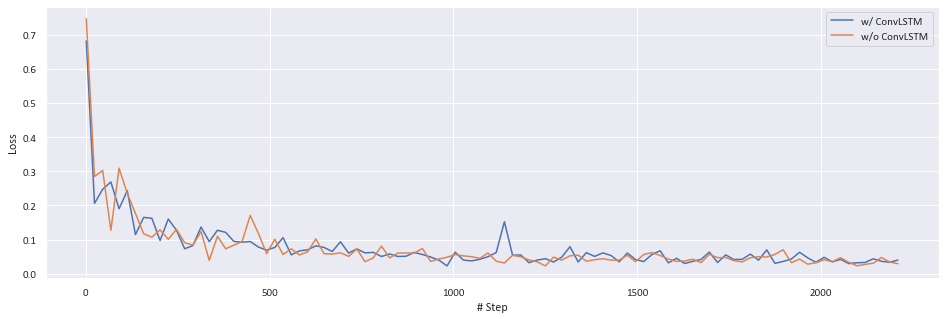

In [291]:
plt.figure(figsize=(16, 5))
for d, c in zip(data, colors):
    loss = d["loss"]
    color = c["color"]
    if loss:
        x = [item.step for item in loss]
        y = [item.value for item in loss]

        smooth = make_interp_spline(x, y)
        x_smooth = np.linspace(np.min(x), np.max(x), 100)
        y_smooth = smooth(x_smooth)
        plt.plot(x_smooth, y_smooth, c=color, label=d["name"])
plt.xlabel("# Step")
plt.ylabel("Loss")
plt.legend()

plt.savefig("report/img/runs.pdf", bbox_inches="tight")

In [510]:
data = [
    dict(name="w/ ConvLSTM", path=r"D:\Downloads\Background Matting\dataset\VideoMatte20KFrames\validConvLSTM366n"),
    dict(name="w/o ConvLSTM", path=r"D:\Downloads\Background Matting\dataset\VideoMatte20KFrames\validConvLSTM366"),
    dict(name="Original", path=r"D:\Downloads\Background Matting\dataset\VideoMatte20KFrames\validOriginal366"),
]

In [511]:
img_per_row = 12

In [512]:
img_count = len(os.listdir(os.path.join(data[0]["path"], "true_src")))
img_count = img_count // 10 * 10
img_count

330

In [513]:
index_list = np.round(np.linspace(0, img_count, img_per_row)).astype(np.int)
index_list.tolist()

[0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]

In [514]:
time_list = (index_list) / 30
time_list = [f"t = {item:.1f}s" for item in time_list]
time_list

['t = 0.0s',
 't = 1.0s',
 't = 2.0s',
 't = 3.0s',
 't = 4.0s',
 't = 5.0s',
 't = 6.0s',
 't = 7.0s',
 't = 8.0s',
 't = 9.0s',
 't = 10.0s',
 't = 11.0s']

In [515]:
def get_img_list(path, index_list, mode="RGB"):
    ret = []
    for i in index_list:
        with Image.open(os.path.join(path, f"{i:06d}.png")) as img:
            ret.append(img.convert(mode))
    return ret

In [516]:
def get_composed_img_list(path, index_list):
    alpha_img_list = get_img_list(os.path.join(path, "pred_pha"), index_list, "L")
    src_img_list = get_img_list(os.path.join(path, "true_src"), index_list)
    assert len(alpha_img_list) == len(src_img_list)
    ret = []
    for i in range(len(src_img_list)):
        alpha = alpha_img_list[i]
        src = src_img_list[i]
        width, height = alpha.size
        matte = np.array(alpha).reshape((width, height, 1)) / 255
        green_background = np.zeros((width, height, 3))
        green_background[:, :, 1] += 255
        ret.append((matte * np.array(src) + (1 - matte) * green_background).astype(np.int))
    return ret

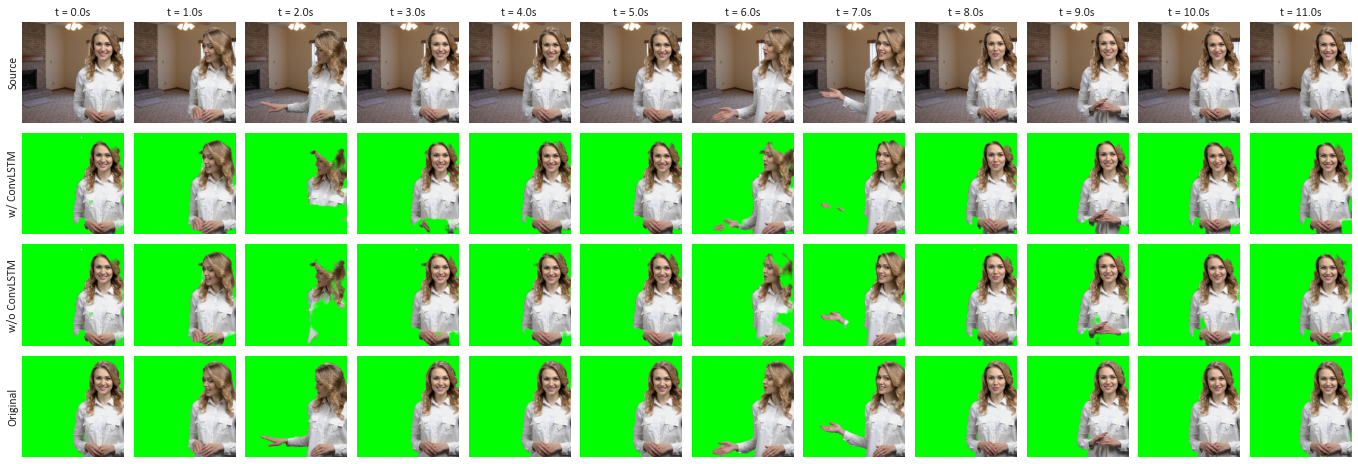

In [517]:
ncol = img_per_row
nrow = len(data) + 1
idx = 0
plt.figure(figsize=(2 * ncol, 2 * nrow))
for col, img in enumerate(
    get_img_list(r"D:\Downloads\Background Matting\dataset\VideoMatte20KFrames\validConvLSTM366\true_src", index_list)
):
    idx += 1
    ax = plt.subplot(nrow, ncol, idx)
    ax.set_xticks([])
    ax.set_yticks([])
    if col == 0:
        ax.set_ylabel("Source")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_title(time_list[col])
    ax.imshow(img)

for row, d in enumerate(data):
    img_list = get_composed_img_list(d["path"], index_list)
    for col, img in enumerate(img_list):
        idx += 1
        ax = plt.subplot(nrow, ncol, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        if col == 0:
            ax.set_ylabel(d["name"])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.imshow(img)
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.savefig("report/img/visual.pdf", bbox_inches="tight", pad_inches=0)

In [576]:
data = [
    dict(name=f"w/ ConvLSTM", path=rf"D:\Downloads\Background Matting\dataset\VideoMatte20KFrames\validConvLSTM71\state_h_42"),
    dict(name=f"w/o ConvLSTM", path=rf"D:\Downloads\Background Matting\dataset\VideoMatte20KFrames\validTransfer71\state_h_42"),
]
data

[{'name': 'w/ ConvLSTM',
  'path': 'D:\\Downloads\\Background Matting\\dataset\\VideoMatte20KFrames\\validConvLSTM71\\state_h_42'},
 {'name': 'w/o ConvLSTM',
  'path': 'D:\\Downloads\\Background Matting\\dataset\\VideoMatte20KFrames\\validTransfer71\\state_h_42'}]

In [561]:
img_count = len(os.listdir(data[0]["path"]))
img_count = img_count // 10 * 10
img_count

230

In [579]:
img_per_row = 3

In [580]:
# index_list = np.round(np.linspace(0, img_count, img_per_row)).astype(np.int)
# index_list.tolist()
index_list = np.array([0, 44, 176])
index_list

array([  0,  44, 176])

In [581]:
time_list = (index_list) / 30
time_list = [f"t = {item:.1f}s" for item in time_list]
time_list

['t = 0.0s', 't = 1.5s', 't = 5.9s']

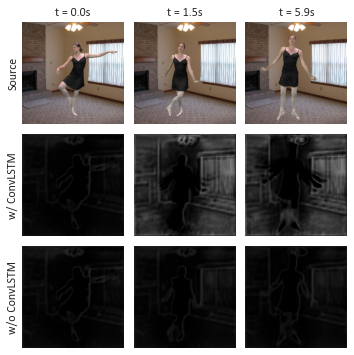

In [585]:
ncol = img_per_row
nrow = len(data) + 1
idx = 0
plt.figure(figsize=(2 * ncol, 2 * nrow))
for col, img in enumerate(
    get_img_list(r"D:\Downloads\Background Matting\dataset\VideoMatte20KFrames\validConvLSTM71\true_src", index_list)
):
    idx += 1
    ax = plt.subplot(nrow, ncol, idx)
    ax.set_xticks([])
    ax.set_yticks([])
    if col == 0:
        ax.set_ylabel("Source")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.set_title(time_list[col])
    ax.imshow(img)

for row, d in enumerate(data):
    img_list = get_img_list(d["path"], index_list)
    for col, img in enumerate(img_list):
        idx += 1
        ax = plt.subplot(nrow, ncol, idx)
        ax.set_xticks([])
        ax.set_yticks([])
        if col == 0:
            ax.set_ylabel(d["name"])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.imshow(img)
plt.subplots_adjust(wspace=0, hspace=0.1)
plt.savefig("report/img/ablationStudy.pdf", bbox_inches="tight", pad_inches=0)

(<matplotlib.image.AxesImage at 0x1fcabf30670>, (2160, 3840, 3))

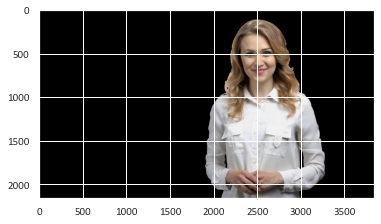

In [442]:
with Image.open(r"D:\Downloads\Background Matting\dataset\VideoMatte240KFrames\train\fgr\0366\0300.jpg") as img:
    fgr = np.array(img.convert("RGB"))
plt.imshow(fgr), fgr.shape

(<matplotlib.image.AxesImage at 0x1fcaba189a0>, (2160, 3840))

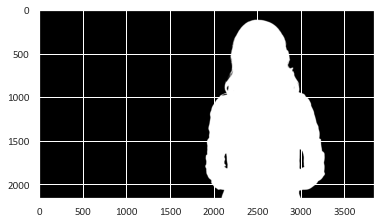

In [443]:
with Image.open(r"D:\Downloads\Background Matting\dataset\VideoMatte240KFrames\train\pha\0366\0300.jpg") as img:
    alpha = np.array(img.convert("L"))
plt.imshow(alpha, cmap="gray"), alpha.shape

In [464]:
cv2.imwrite('report/img/demo2.png', alpha)

True

(<matplotlib.image.AxesImage at 0x1fcaa418070>, (1536, 2048, 3))

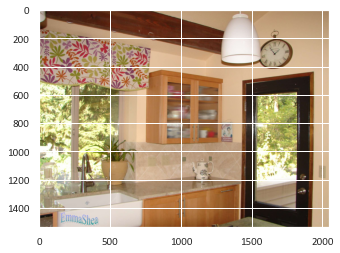

In [444]:
with Image.open(r"D:\Downloads\Background Matting\dataset\Backgrounds\interior_design_0134.jpg") as img:
    bgr = np.array(img.convert("RGB"))
plt.imshow(bgr), bgr.shape

(<matplotlib.image.AxesImage at 0x1fca9f941f0>, (2160, 3840, 3))

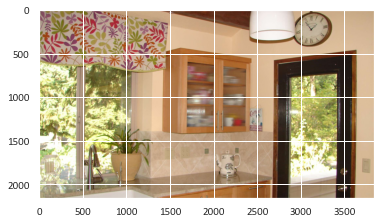

In [445]:
def resize_crop(img, height, width):
    h, w = img.shape[:2]
    r = max(height / h, width / w)
    new_w = int(r * w)
    new_h = int(r * h)
    ret = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_CUBIC)
    w_start = new_w // 2 - width // 2
    h_start = new_h // 2 - height // 2
    return ret[h_start : h_start + height, w_start : w_start + width, :]


bgr = resize_crop(bgr, *alpha.shape)
plt.imshow(bgr), bgr.shape

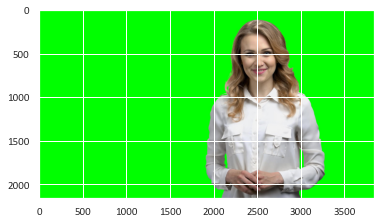

In [456]:
def add_background(fgr, alpha, background, output_pathname=None):
    matte = alpha.reshape((*alpha.shape, 1)) / 255
    img = (matte * fgr + (1 - matte) * background).astype(np.int)
    plt.imshow(img)
    if output_pathname is not None:
        cv2.imwrite(output_pathname, img[:,:,::-1])


# green_background = np.zeros(fgr.shape)
# green_background[:, :, 1] += 255
# add_background(fgr, alpha, green_background, 'report/img/demo2.png')

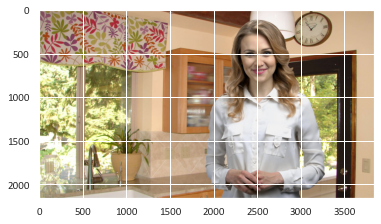

In [457]:
add_background(fgr, alpha, bgr, 'report/img/demo1.png')

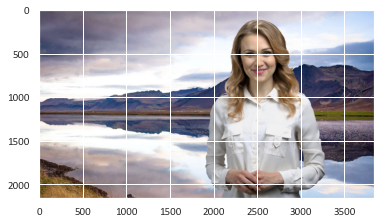

In [458]:
with Image.open(r"D:\Downloads\Background Matting\dataset\Backgrounds\landscape_0144.jpg") as img:
    bgr1 = np.array(img.convert("RGB"))
add_background(fgr, alpha, resize_crop(bgr1, *alpha.shape), 'report/img/demo3.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


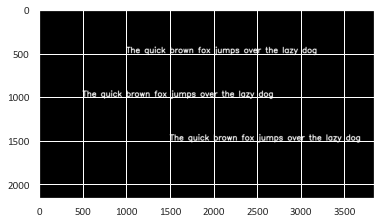

In [459]:
bgr2 = cv2.putText(np.zeros(fgr.shape), 'The quick brown fox jumps over the lazy dog', (1000, 500), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 255), 10)
bgr2 = cv2.putText(bgr2, 'The quick brown fox jumps over the lazy dog', (500, 1000), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 255), 10)
bgr2 = cv2.putText(bgr2, 'The quick brown fox jumps over the lazy dog', (1500, 1500), cv2.FONT_HERSHEY_SIMPLEX, 3, (255, 255, 255), 10)
plt.imshow(bgr2)

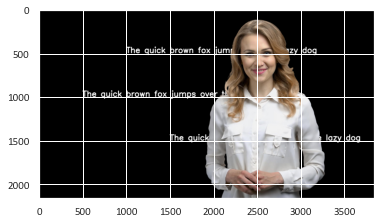

In [460]:
add_background(fgr, alpha, resize_crop(bgr2, *alpha.shape), 'report/img/demo4.png')